In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

TRAIN_PATH = 'PATH'
TEST_PATH = 'PATH'
SUBMISSION_PATH = 'PATH'

SEED = 12345


def load_data(train_path,
              test_path,
              submission_path):
  

    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    submission = pd.read_csv(submission_path)

    return train, test, submission

data_train, data_test, submission = load_data(TRAIN_PATH,
                                              TEST_PATH,
                                              SUBMISSION_PATH)

In [ ]:
data_train.isna().mean()

ID                  0.000000
Код_группы          0.000000
Год_Поступления     0.000000
Пол                 0.000515
Основания           0.000000
Изучаемый_Язык      0.060807
Дата_Рождения       0.000000
Уч_Заведение        0.090769
Где_Находится_УЗ    0.101664
Год_Окончания_УЗ    0.095701
Пособие             0.074205
Страна_ПП           0.025545
Регион_ПП           0.045495
Город_ПП            0.032612
Общежитие           0.006331
Наличие_Матери      0.000000
Наличие_Отца        0.000000
Страна_Родители     0.033716
Опекунство          0.000000
Село                0.006331
Иностранец          0.022821
КодФакультета       0.000000
СрБаллАттестата     0.000000
Статус              0.000000
dtype: float64

In [ ]:
data_test.isna().mean()

ID                  0.000000
Код_группы          0.000000
Год_Поступления     0.000000
Пол                 0.000448
Основания           0.000000
Изучаемый_Язык      0.059184
Дата_Рождения       0.000000
Уч_Заведение        0.086385
Где_Находится_УЗ    0.098640
Год_Окончания_УЗ    0.092213
Пособие             0.072336
Страна_ПП           0.023913
Регион_ПП           0.043342
Город_ПП            0.031983
Общежитие           0.005231
Наличие_Матери      0.000000
Наличие_Отца        0.000000
Страна_Родители     0.029592
Опекунство          0.000000
Село                0.005530
Иностранец          0.019429
КодФакультета       0.000000
СрБаллАттестата     0.000000
dtype: float64

In [ ]:
def clean_data(data_train,
               data_test):
  
  #Год_Поступления
  delete_admission_index = data_train[data_train['Год_Поступления'] > 2020].index # удаление выброса 2212 год поступления
  data_train = data_train.drop(labels=delete_admission_index, axis=0)
  data_train['Год_Поступления'] = data_train['Год_Поступления'].astype(np.int16)
  data_test['Год_Поступления'] = data_test['Год_Поступления'].astype(np.int16)

  #Пол
  filled_value = data_train['Пол'].value_counts().nlargest(1).index[0]
  data_train['Пол'] = data_train['Пол'].fillna(filled_value)
  data_test['Пол'] = data_test['Пол'].fillna(filled_value)
  sex_map = {'Жен': 1.0,
             'Муж' : 0.0,
             'муж' : 0.0,
             'жен' : 1.0}
  data_train['Пол'] = data_train['Пол'].map(sex_map)
  data_test['Пол'] = data_test['Пол'].map(sex_map)
  data_train['Пол'] = data_train['Пол'].astype(np.int8)
  data_test['Пол'] = data_test['Пол'].astype(np.int8)

  #Основания
  reason_map = {'СН': 1,
                'ЦН' : 2,
                'БН' : 3,
                'ОО' : 4,
                'ДН' : 5,
                'ЛН' : 4}
  data_train['Основания'] = data_train['Основания'].map(reason_map)
  data_test['Основания'] = data_test['Основания'].map(reason_map)
  data_train['Основания'] = data_train['Основания'].astype(np.int8) 
  data_test['Основания'] = data_test['Основания'].astype(np.int8)

  #Изучаемый_Язык
  filled_value = data_train['Изучаемый_Язык'].value_counts().nlargest(1).index[0]
  data_train['Изучаемый_Язык'] = data_train['Изучаемый_Язык'].fillna(filled_value)
  data_test['Изучаемый_Язык'] = data_test['Изучаемый_Язык'].fillna(filled_value)
  language_map = {'Английский язык' : 1,
                 'Немецкий язык' : 2,
                 'Французский язык' : 3,
                 'Англиийский' : 1,
                 'Иностранный язык (Английский)' : 1,
                 'Русский язык' : 4,
                 'Английский, немецкий языки' : 1,
                 'Иностранный язык (Немецкий)' : 2}

  data_train['Изучаемый_Язык'] = data_train['Изучаемый_Язык'].map(language_map)
  data_test['Изучаемый_Язык'] = data_test['Изучаемый_Язык'].map(language_map)
  data_train['Изучаемый_Язык'] = data_train['Изучаемый_Язык'].astype(np.int8)
  data_test['Изучаемый_Язык'] = data_test['Изучаемый_Язык'].astype(np.int8)

  #Дата_Рождения
  data_train['Дата_Рождения'] = pd.to_datetime(data_train['Дата_Рождения']).apply(lambda date: date.year)
  data_test['Дата_Рождения'] = pd.to_datetime(data_test['Дата_Рождения']).apply(lambda date: date.year)
  data_train['Дата_Рождения'] = data_train['Дата_Рождения'].astype(np.int16)
  data_test['Дата_Рождения'] = data_test['Дата_Рождения'].astype(np.int16)

  delete_birth_index = data_train[data_train['Дата_Рождения'] > 2004].index
  data_train = data_train.drop(labels=delete_birth_index, axis=0)

  #Уч_Заведение
  filled_value = data_train['Уч_Заведение'].value_counts().nlargest(1).index[0]
  data_train['Уч_Заведение'] = data_train['Уч_Заведение'].fillna(filled_value)
  data_test['Уч_Заведение'] = data_test['Уч_Заведение'].fillna(filled_value)
  data_train['Уч_Заведение'] = data_train['Уч_Заведение'].astype('object')
  data_test['Уч_Заведение'] = data_test['Уч_Заведение'].astype('object')

  #Где_Находится_УЗ
  filled_value = data_train['Где_Находится_УЗ'].value_counts().nlargest(1).index[0]
  data_train['Где_Находится_УЗ'] = data_train['Где_Находится_УЗ'].fillna(filled_value)
  data_test['Где_Находится_УЗ'] = data_test['Где_Находится_УЗ'].fillna(filled_value)
  data_train['Где_Находится_УЗ'] = data_train['Где_Находится_УЗ'].astype('object')
  data_test['Где_Находится_УЗ'] = data_test['Где_Находится_УЗ'].astype('object')

  #Год_Окончания_УЗ (какой эвристикой заполнить данное поле?)
  filled_value = data_train['Год_Окончания_УЗ'].value_counts().nlargest(1).index[0]
  data_train['Год_Окончания_УЗ'] = data_train['Год_Окончания_УЗ'].fillna(filled_value)
  data_test['Год_Окончания_УЗ'] = data_test['Год_Окончания_УЗ'].fillna(filled_value)
  data_train['Год_Окончания_УЗ'] = data_train['Год_Окончания_УЗ'].astype(np.int16)
  data_test['Год_Окончания_УЗ'] = data_test['Год_Окончания_УЗ'].astype(np.int16)

  #Страна_ПП
  filled_value = data_train['Страна_ПП'].value_counts().nlargest(1).index[0]
  data_train['Страна_ПП'] = data_train['Страна_ПП'].fillna(filled_value)
  data_test['Страна_ПП'] = data_test['Страна_ПП'].fillna(filled_value)
  data_train['Страна_ПП'] = data_train['Страна_ПП'].astype('object')
  data_test['Страна_ПП'] = data_test['Страна_ПП'].astype('object')

  #Регион_ПП
  filled_value = data_train['Регион_ПП'].value_counts().nlargest(1).index[0]
  data_train['Регион_ПП'] = data_train['Регион_ПП'].fillna(filled_value)
  data_test['Регион_ПП'] = data_test['Регион_ПП'].fillna(filled_value)
  data_train['Регион_ПП'] = data_train['Регион_ПП'].astype('object')
  data_test['Регион_ПП'] = data_test['Регион_ПП'].astype('object')

  #Город_ПП
  filled_value = data_train['Город_ПП'].value_counts().nlargest(1).index[0]
  data_train['Город_ПП'] = data_train['Город_ПП'].fillna(filled_value)
  data_test['Город_ПП'] = data_test['Город_ПП'].fillna(filled_value)
  data_train['Город_ПП'] = data_train['Город_ПП'].astype('object')
  data_test['Город_ПП'] = data_test['Город_ПП'].astype('object')

  #Общежитие
  filled_value = data_train['Общежитие'].value_counts().nlargest(1).index[0]
  data_train['Общежитие'] = data_train['Общежитие'].fillna(filled_value)
  data_test['Общежитие'] = data_test['Общежитие'].fillna(filled_value)
  data_train['Общежитие'] = data_train['Общежитие'].astype(np.int16)
  data_test['Общежитие'] = data_test['Общежитие'].astype(np.int16)

  #Наличие_Матери
  data_train['Наличие_Матери'] = data_train['Наличие_Матери'].astype(np.int16)
  data_test['Наличие_Матери'] = data_test['Наличие_Матери'].astype(np.int16)

  #Наличие_Отца
  data_train['Наличие_Отца'] = data_train['Наличие_Отца'].astype(np.int16)
  data_test['Наличие_Отца'] = data_test['Наличие_Отца'].astype(np.int16)

  #Страна_Родители
  filled_value = data_train['Страна_Родители'].value_counts().nlargest(1).index[0]
  data_train['Страна_Родители'] = data_train['Страна_Родители'].fillna(filled_value)
  data_test['Страна_Родители'] = data_test['Страна_Родители'].fillna(filled_value)
  data_train['Страна_Родители'] = data_train['Страна_Родители'].astype('object')
  data_test['Страна_Родители'] = data_test['Страна_Родители'].astype('object')

  #Село
  filled_value = data_train['Село'].value_counts().nlargest(1).index[0]
  data_train['Село'] = data_train['Село'].fillna(filled_value)
  data_test['Село'] = data_test['Село'].fillna(filled_value)
  data_train['Село'] = data_train['Село'].astype(np.int16)
  data_test['Село'] = data_test['Село'].astype(np.int16)

  #Иностранец
  filled_value = data_train['Иностранец'].value_counts().nlargest(1).index[0]
  data_train['Иностранец'] = data_train['Иностранец'].fillna(filled_value)
  data_test['Иностранец'] = data_test['Иностранец'].fillna(filled_value)
  data_train['Иностранец'] = data_train['Иностранец'].astype(np.int16)
  data_test['Иностранец'] = data_test['Иностранец'].astype(np.int16)

  #КодФакультета
  data_train['КодФакультета'] = data_train['КодФакультета'].astype(np.int16)
  data_test['КодФакультета'] = data_test['КодФакультета'].astype(np.int16)

  #СрБаллАттестата
  data_train['СрБаллАттестата'] = data_train['СрБаллАттестата'].astype(np.int16)
  data_test['СрБаллАттестата'] = data_test['СрБаллАттестата'].astype(np.int16)

  delete_gpa_index = data_train[data_train['СрБаллАттестата'] > 100].index
  data_train = data_train.drop(labels=delete_gpa_index, axis=0)

  features, target = data_train.drop(columns=['ID', 'Пособие', 'Опекунство', 'Статус']), data_train['Статус']
  test = data_test.drop(columns=['ID', 'Пособие', 'Опекунство'])

  return features, target, test

In [ ]:
features, target, test = clean_data(data_train, data_test)

In [ ]:
features.shape

(13526, 20)

In [ ]:
def create_feature(train,
                   test):
  
  #Длина наименования учебного заведения
  train['Длина_УЗ'] = train['Уч_Заведение'].apply(lambda val: len(val))
  test['Длина_УЗ'] = test['Уч_Заведение'].apply(lambda val: len(val))

  #Длина группы
  def _return_digits(n, i):
    j = 0
    while j < i:

      cur, d = divmod(n, 10)
      n = cur
      j += 1

    return n

  train['Один_знак'] = train['Код_группы'].apply(_return_digits, i=4)
  train['Два_знака'] = train['Код_группы'].apply(_return_digits, i=3)
  train['Три_знака'] = train['Код_группы'].apply(_return_digits, i=2)
  train['Четыре_знака'] = train['Код_группы'].apply(_return_digits, i=1)

  test['Один_знак'] = test['Код_группы'].apply(_return_digits, i=4)
  test['Два_знака'] = test['Код_группы'].apply(_return_digits, i=3)
  test['Три_знака'] = test['Код_группы'].apply(_return_digits, i=2)
  test['Четыре_знака'] = test['Код_группы'].apply(_return_digits, i=1)

  #Приведение Уч_Заведение к единому типу
  def _return_edu_institution(value):

    value = value.lower()

    if 'университет' in value:
      return 1
    if 'школа' in value:
      return 2
    if 'лицей' in value:
      return 3
    if 'колледж' in value:
      return 4
    if 'институт' in value:
      return 5
    if 'академия' in value:
      return 6
    if 'гимназия' in value:
      return 7
    if 'техникум' in value:
      return 8
    if 'сош' in value:
      return 2

    return 9

  train['Тип_заведения'] = train['Уч_Заведение'].apply(_return_edu_institution)
  test['Тип_заведения'] = test['Уч_Заведение'].apply(_return_edu_institution)
  train['Тип_заведения'] = train['Тип_заведения'].astype(np.int8)
  test['Тип_заведения'] = test['Тип_заведения'].astype(np.int8)

  #Признаки на дате рождения
  train['Поступление_рождение'] = train['Год_Поступления'] - train['Дата_Рождения']
  test['Поступление_рождение'] = test['Год_Поступления'] - test['Дата_Рождения']
  train['Выпуск_рождение'] = train['Год_Поступления'] - train['Дата_Рождения']
  test['Выпуск_рождение'] = test['Год_Поступления'] - test['Дата_Рождения']
  train['Выпуск_поступление'] = train['Год_Окончания_УЗ'] - train['Год_Поступления']
  test['Выпуск_поступление'] = test['Год_Окончания_УЗ'] - test['Год_Поступления']

  #СрБалАттестата (перевод в шкалу от 5 до 100 с грубым коэф.17, но тут можно эксперементировать)
  train['СрБаллАттестата'] = train['СрБаллАттестата'].apply(lambda score: score if score > 5 else score*17)
  test['СрБаллАттестата'] = test['СрБаллАттестата'].apply(lambda score: score if score > 5 else score*17)

  #Информация о семье
  train['Полная_семья'] = train['Наличие_Матери'] & train['Наличие_Отца']
  test['Полная_семья'] = test['Наличие_Матери'] & test['Наличие_Отца']
  train['Полная_семья'] = train['Полная_семья'].astype(np.int8)
  test['Полная_семья'] = test['Полная_семья'].astype(np.int8)

  train['Сироты'] = ((train['Наличие_Отца']==0) & (train['Наличие_Матери']==0)) * 1
  test['Сироты'] = ((test['Наличие_Отца']==0) & (test['Наличие_Матери']==0)) * 1
  train['Сироты'] = train['Сироты'].astype(np.int8)
  test['Сироты'] = test['Сироты'].astype(np.int8)

  #Информация об аттестатах
  def _return_gpa(value):
    
    if value < 30:
      return 1 #Очень низкий бал
    if value < 50:
      return 2 #Низкий бал
    if value <70:
      return 3 #Норм
    if value < 80:
      return 4 #Высокий
    if value < 90:
      return 5 #Очень высокий    
    return 6 # Очень-очень высокий
    
  train['Группа_бал'] = train['СрБаллАттестата'].apply(_return_gpa)
  test['Группа_бал'] = test['СрБаллАттестата'].apply(_return_gpa)
  train['Группа_бал'] = train['Группа_бал'].astype(np.int8)
  test['Группа_бал'] = test['Группа_бал'].astype(np.int8)

  #Где_Находится_УЗ
  def _return_place_institution(value):

    value = value.lower()

    if 'барнаул' in value:
      return 1
    if 'бийск' in value:
      return 2
    if 'москва' in value:
      return 3
    if 'санкт-перетбург' in value:
      return 4
    if 'казахстан' in value:
      return 5
    if 'алтай' in value:
      return 6

    return 9  

  train['Место_заведения'] = train['Где_Находится_УЗ'].apply(_return_place_institution)
  test['Место_заведения'] = test['Где_Находится_УЗ'].apply(_return_place_institution)
  train['Место_заведения'] = train['Место_заведения'].astype(np.int8)
  test['Место_заведения'] = test['Место_заведения'].astype(np.int8)

  #Возрастная_группа
  def _return_age_group(value):

    if value < 1960:
      return 1
    if value < 1970:
      return 2
    if value < 1980:
      return 3
    if value < 1990:
      return 4
    if value < 2000:
      return 5

    return 6

  train['Возрастная_группа'] = train['Дата_Рождения'].apply(_return_age_group)
  test['Возрастная_группа'] = test['Дата_Рождения'].apply(_return_age_group)
  train['Возрастная_группа'] = train['Возрастная_группа'].astype(np.int8)
  test['Возрастная_группа'] = test['Возрастная_группа'].astype(np.int8)

  train = train.drop(columns=['Уч_Заведение', 'Где_Находится_УЗ'])
  test = test.drop(columns=['Уч_Заведение', 'Где_Находится_УЗ'])


  return train, test

In [ ]:
train, test = create_feature(features, test)

In [ ]:
train.sample(1)

,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Год_Окончания_УЗ,Страна_ПП,Регион_ПП,Город_ПП,...,Четыре_знака,Тип_заведения,Поступление_рождение,Выпуск_рождение,Выпуск_поступление,Полная_семья,Сироты,Группа_бал,Место_заведения,Возрастная_группа
3893,22172,2017,1,1,1,1999,2017,Россия,Алтайский край,Барнаул г,...,2217,9,18,18,0,1,0,3,5,5


In [ ]:
INT_FEATURES = [
    'Год_Поступления', 
    'Дата_Рождения', 
    'Год_Окончания_УЗ', 
    'СрБаллАттестата', 
    'Поступление_рождение', 
    'Выпуск_рождение', 
    'Выпуск_поступление',
    'Длина_УЗ']

CAT_FEATURES = [
 'Код_группы',
 'Один_знак',
 'Два_знака',
 'Три_знака',
 'Четыре_знака',
 'Пол',
 'Основания',
 'Изучаемый_Язык',
 'Страна_ПП',
 'Общежитие',
 'Наличие_Матери',
 'Наличие_Отца',
 'Страна_Родители',
 'Село',
 'Иностранец',
 'КодФакультета',
 'Сироты',
 'Полная_семья',
 'Группа_бал',
 'Тип_заведения',
 'Место_заведения',
 'Регион_ПП',
 'Город_ПП',
 'Возрастная_группа']

len(INT_FEATURES) + len(CAT_FEATURES) == test.shape[1]

True

In [ ]:
train[CAT_FEATURES] = train[CAT_FEATURES].astype('category')
test[CAT_FEATURES] = test[CAT_FEATURES].astype('category')

**Валидация и поиск гиперпараметров**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target,test_size=0.15, stratify=target,
                                                      shuffle=True, random_state=SEED)

In [ ]:
model = CatBoostClassifier(
    loss_function='MultiClass', 
    verbose=False,
    random_state=SEED,
    cat_features=CAT_FEATURES,
    auto_class_weights='Balanced',
    eval_metric='TotalF1:average=Macro')

model.fit(X_train, y_train)

predict_valid = model.predict(X_valid)
predict_train = model.predict(X_train)



print('Метрика F1 на тренировочной выборке:', f1_score(y_train, predict_train, average='macro', zero_division = 0))
print('Метрика F1 на валидационной выборке:', f1_score(y_valid, predict_valid, average='macro', zero_division = 0))

Метрика F1 на тренировочной выборке: 0.8899635310142022
Метрика F1 на валидационной выборке: 0.7801253775620299


**Optuna**

In [ ]:
import optuna

In [ ]:
from ipywidgets.widgets.interaction import Parameter

def objective(trial):
    
    train_x, valid_x, train_y, valid_y = train_test_split(train, target, stratify=target, test_size=0.3,
                                                          shuffle=True, random_state=SEED)

    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.03, 0.05, 0.06, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'random_seed': SEED,
        'cat_features' : CAT_FEATURES,
        'auto_class_weights' : 'Balanced',
        'eval_metric' : 'TotalF1:average=Macro'

    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostClassifier(**param)

    cb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=False, early_stopping_rounds=250)

    preds = cb.predict(valid_x)
    pred_labels = np.rint(preds)
    f_1 = f1_score(valid_y, pred_labels, average='macro', zero_division = 0)

    return f_1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [ ]:
params = {'objective': 'MultiClass', 
          'colsample_bylevel': 0.09193906043107654, 
          'depth': 10, 
          'boosting_type': 'Ordered', 
          'bootstrap_type': 'MVS', 
          'learning_rate': 0.05, 
          'n_estimators': 1404, 
          'max_bin': 224, 
          'min_data_in_leaf': 128, 
          'l2_leaf_reg': 0.04355511389301864,
          'verbose' : False,
          'random_state' : SEED,
          'cat_features' : CAT_FEATURES,
          'auto_class_weights' : 'Balanced',
          'eval_metric' : 'TotalF1:average=Macro'
          }

**Скор лучшей модели**

In [ ]:
best_model = CatBoostClassifier(**params)

best_model.fit(X_train, y_train)

predict_valid = best_model.predict(X_valid)
predict_train = best_model.predict(X_train)



print('Метрика F1 на тренировочной выборке:', f1_score(y_train, predict_train, average='macro', zero_division = 0))
print('Метрика F1 на валидационной выборке:', f1_score(y_valid, predict_valid, average='macro', zero_division = 0))

Метрика F1 на тренировочной выборке: 0.9213296390742015
Метрика F1 на валидационной выборке: 0.7951313649162715


**Feature Importance, SHAP feature importance**

In [ ]:
import shap
from catboost import Pool

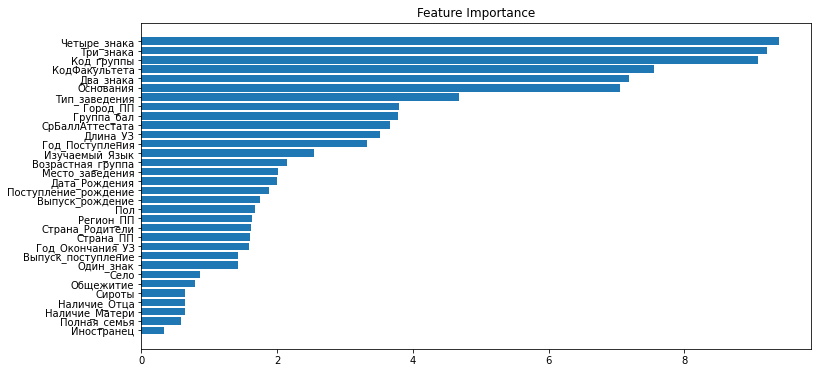

In [ ]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.savefig('feature_importance.png');

In [ ]:
explainer = shap.TreeExplainer(best_model)

X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)

shap_values = explainer.shap_values(Pool(X_train_subs, y_train_subs, cat_features=CAT_FEATURES))

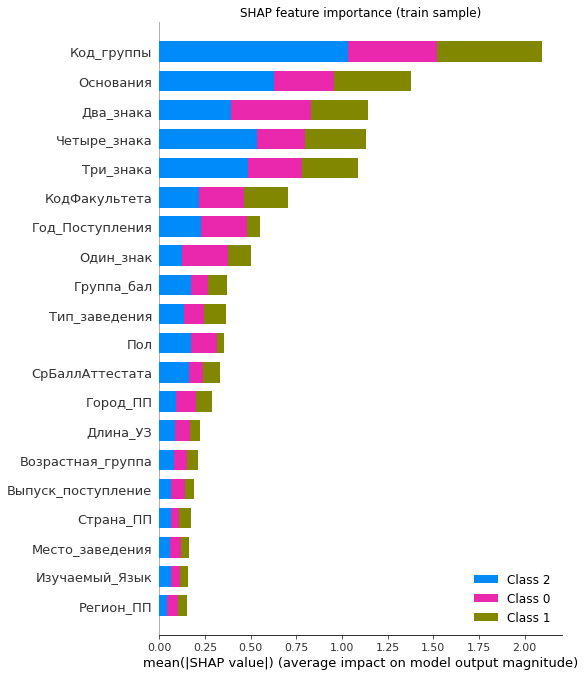

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("SHAP feature importance (train sample)")

shap.summary_plot(shap_values, X_train_subs)

plt.savefig('SHAP_feature_importance.png');

**Сабмит**

In [ ]:
cb = CatBoostClassifier(**params)
cb.fit(train, target)
predict_test = cb.predict(test)
submission["Статус"] = predict_test
submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,-1
3,73673,-1


In [ ]:
submission.to_csv("complete_solution.csv", index=False)